In [41]:
import eredivisie_nlp as enlp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix, mean_absolute_error, accuracy_score
from sklearn.model_selection import train_test_split
from statsmodels.api import OLS

In [2]:
df_total = pd.read_pickle(enlp.determine_root() + "/data/grades+twitter.pkl")
# normalize the fotmob scores, to have the same average as AD and VI
df_total.FM = df_total.FM - 1
df_total.reset_index(inplace=True, drop=True)

In [3]:
df_players = df_total[df_total.player_id.str.contains("match_") == False]
players = pd.read_csv(enlp.determine_root() + "/data/players.csv", index_col=[0])
df_players = df_players.merge(players[['position', 'player_id']], on='player_id')

# Plot dataset size dependent on criterium of num_tweets

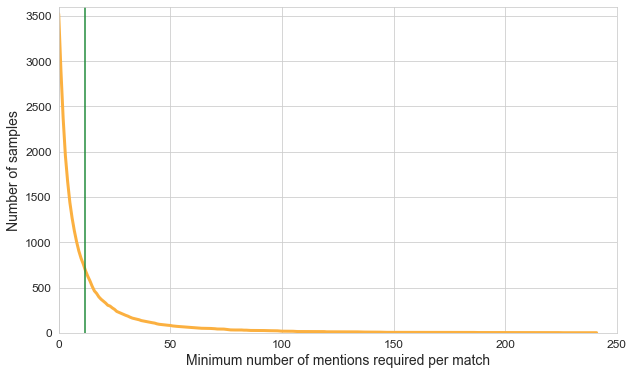

In [4]:
sizes = [df_players[df_players.num_tweets > x].shape[0] for x in range(0, 242)]
fig = plt.figure(figsize=[10,6])
plt.plot(sizes, color = '#fbb040', linewidth=3)
plt.xlim([0, 250])
plt.ylim(0, 3600)
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel('Minimum number of mentions required per match', size=14)
plt.ylabel('Number of samples', size=14)
plt.vlines(12, ymin=0, ymax=3600, color='#208b3a')
plt.show()

In [40]:
working_df = df_players[df_players.num_tweets > 12].reset_index(drop=True)

# Plot heatmaps

In [47]:
def get_heatmap(media_source, twitter_source, df, acc=False):
    # get necessary data
    media = np.zeros(df.shape[0])
    if media_source == 'AD':
        above = df[media_source] > 6.9
        below = df[media_source] < 6
    elif media_source == 'VI':
        above = df[media_source] > 6.9
        below = df[media_source] < 5.6
    elif media_source == 'FM':
        above = df[media_source] > 6.5
        below = df[media_source] < 5.5

    # set media grades
    for x in range(len(media)):
        if above[x]:
            media[x] = 2
        elif below[x]:
            media[x] = 0
        else:
            media[x] = 1


    twitter = np.zeros(df.shape[0])
    column2 = f'score_{twitter_source.lower()}'
    above = df[column2] > 0
    below = df[column2] < 0

    # set twitter grades
    for x in range(len(twitter)):
        if above[x]:
            twitter[x] = 2
        elif below[x]:
            twitter[x] = 0
        else:
            twitter[x] = 1

    if acc:
        return accuracy_score(media, twitter)
    else:
        return confusion_matrix(media, twitter, labels=[0, 1, 2])

In [60]:
media = ['AD', 'AD', 'VI', 'VI', 'FM', 'FM']
twitter = ['RobBERT', 'pattern', 'RobBERT', 'pattern', 'RobBERT', 'pattern']
accs = [get_heatmap(m, t, df=working_df, acc=True) for m, t in zip(media, twitter)]
robbert_acc = sum([accs[0], accs[2], accs[4]]) / 3
pattern_acc = sum([accs[1], accs[3], accs[5]]) / 3

In [62]:
robbert_acc, pattern_acc

(0.5150631681243926, 0.4164237123420797)

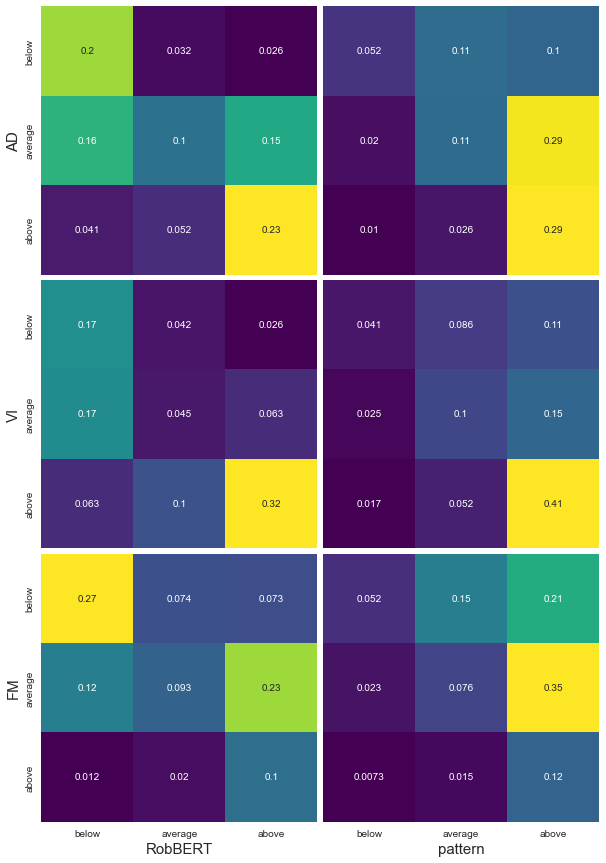

In [44]:
axis_labels = ['below', 'average', 'above']

_, axs = plt.subplots(nrows = 3, ncols = 2, figsize=[10,15])
cf = get_heatmap('AD', 'RobBERT', working_df)
sns.heatmap(cf/np.sum(cf), annot=True, xticklabels=False, yticklabels=axis_labels, cmap=sns.color_palette("viridis", as_cmap=True), cbar=False, ax=axs[0,0])
cf = get_heatmap('AD', 'pattern', working_df)
sns.heatmap(cf/np.sum(cf), annot=True, xticklabels=False, yticklabels=False, cmap=sns.color_palette("viridis", as_cmap=True), cbar=False, ax=axs[0,1])
cf = get_heatmap('VI', 'RobBERT', working_df)
sns.heatmap(cf/np.sum(cf), annot=True, xticklabels=False, yticklabels=axis_labels, cmap=sns.color_palette("viridis", as_cmap=True), cbar=False, ax=axs[1,0])
cf = get_heatmap('VI', 'pattern', working_df)
sns.heatmap(cf/np.sum(cf), annot=True, xticklabels=False, yticklabels=False, cmap=sns.color_palette("viridis", as_cmap=True), cbar=False, ax=axs[1,1])
cf = get_heatmap('FM', 'RobBERT', working_df)
sns.heatmap(cf/np.sum(cf), annot=True, xticklabels=axis_labels, yticklabels=axis_labels, cmap=sns.color_palette("viridis", as_cmap=True), cbar=False, ax=axs[2,0])
cf = get_heatmap('FM', 'pattern', working_df)
sns.heatmap(cf/np.sum(cf), annot=True, xticklabels=axis_labels, yticklabels=False, cmap=sns.color_palette("viridis", as_cmap=True), cbar=False, ax=axs[2,1])

axs[0,0].set_ylabel('AD', size=15)
axs[1,0].set_ylabel('VI', size=15)
axs[2,0].set_ylabel('FM', size=15)
axs[2,0].set_xlabel('RobBERT', size=15)
axs[2,1].set_xlabel('pattern', size=15)

plt.subplots_adjust(wspace=0.02, hspace=0.02)

plt.savefig(enlp.determine_root() + "/res/figures/general_heatmaps_players.png", dpi=600)

plt.show()

# Figure 2, predictive power of Twitter scores for Media grades

In [22]:
working_df[['AD', 'VI', 'FM', 'score_pattern', 'score_robbert']].corr()

,AD,VI,FM,score_pattern,score_robbert
AD,1.000000,0.757034,0.672835,0.444205,0.539899
VI,0.757034,1.000000,0.777701,0.411706,0.548634
FM,0.672835,0.777701,1.000000,0.292728,0.401940
score_pattern,0.444205,0.411706,0.292728,1.000000,0.607614
score_robbert,0.539899,0.548634,0.401940,0.607614,1.000000


In [30]:
def lin_reg(media, df):
    print(f"Values for: {media}")
    X = df.score_robbert.values.reshape(-1, 1)
    y = df[media].values.reshape(-1, 1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    regressor = LinearRegression()

    regressor.fit(X_train, y_train)

    print(OLS(y_train,X_train).fit().summary())

    print(f"Intercept: {round(regressor.intercept_[0], 2)}")
    print(f"Coefficient: {round(regressor.coef_[0][0], 2)}")

    y_pred = regressor.predict(X_test)

    print(f"MAE: {round(mean_absolute_error(y_test, y_pred), 2)}")

lin_reg('AD', working_df[np.isnan(working_df.score_robbert) == False])

Values for: AD
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.003
Model:                            OLS   Adj. R-squared (uncentered):              0.001
Method:                 Least Squares   F-statistic:                              1.737
Date:                Fri, 24 Jun 2022   Prob (F-statistic):                       0.188
Time:                        17:30:24   Log-Likelihood:                         -1789.5
No. Observations:                 548   AIC:                                      3581.
Df Residuals:                     547   BIC:                                      3585.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

# Additional analyses for different sections

In [10]:
# section 4.1
no_data = df_players.num_tweets[df_players.num_tweets == 0].shape[0]
print(f"No data for {no_data} out of {df_players.shape[0]} player appearances.")

No data for 830 out of 4351 player appearances.


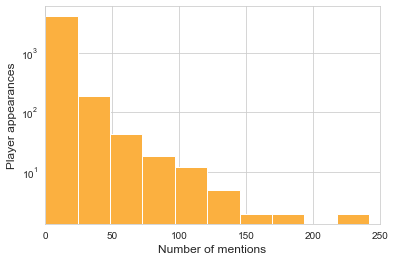

In [11]:
# section 4.1
plt.hist(df_players.num_tweets, color='#fbb040')
plt.yscale('log')
plt.xlabel('Number of mentions', size=12)
plt.ylabel('Player appearances', size=12)
plt.savefig(enlp.determine_root() + "/res/figures/num_tweets.png", dpi=600)
plt.xlim([0, 250])
plt.show()

In [12]:
roles_recode = {
    'Centre-Back': 'back',
    'Centre-Forward': 'forward',
    'Right-Back': 'back',
    'Attacking Midfield': 'midfield',
    'Central Midfield': 'midfield',
    'Defensive Midfield': 'midfield',
    'Left-Back': 'back',
    'Goalkeeper': 'goalkeeper',
    'Right Winger': 'forward',
    'Left Winger': 'forward',
    'Right Midfield': 'midfield',
    'Left Midfield': 'midfield'
}
df_players['position_std'] = df_players.position.map(roles_recode)
goalies = df_players[df_players.position_std == 'goalkeeper'].num_tweets
back = df_players[df_players.position_std == 'back'].num_tweets
midfield = df_players[df_players.position_std == 'midfield'].num_tweets
forward = df_players[df_players.position_std == 'forward'].num_tweets

In [13]:
print(sum(goalies) / len(goalies))
print(sum(back) / len(back))
print(sum(midfield) / len(midfield))
print(sum(forward) / len(forward))

11.554878048780488
4.329946204423192
6.876377952755906
11.262037037037038
